# black-box regression results

Generates figures comparing performance on the black-box regression problems.

In [1]:
import pandas as pd
import json
import numpy as np
from glob import glob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('pdf', fonttype=42)
import os
sns.set(font_scale=1.25, style='whitegrid')

rdir = '../results/'
figdir = 'figs/black-box' 
print('figdir:',figdir)
def save(h=None,name='tmp'):
    name = name.strip().replace(' ','-').replace('%','pct')
    if h == None:
        h = plt.gcf()
    h.tight_layout()
    print('saving',figdir+'/'+name+'.pdf')
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    plt.savefig(figdir+'/'+name+'.pdf', bbox_inches='tight')
    
symbolic_algs = [
    'AFP', 
    'AFP_FE',
    'BSR',
    'DSR',
    'FFX',
    'FEAT',
    'EPLEX',
    'GP-GOMEA',
    'gplearn',
    'ITEA', 
    'MRGP', 
    'Operon',
    'SBP-GP',
    'AIFeynman'
]
nongp_algs = [
    'BSR',
    'DSR',
    'AIFeynman'
]
gp_algs = [
    'AFP', 
    'AFP_FE',
    'FFX',
    'FEAT',
    'EPLEX',
    'GP-GOMEA',
    'gplearn',
    'ITEA', 
    'MRGP', 
    'Operon',
    'SBP-GP',
]

figdir: figs/black-box


# read data from feather

In [2]:
df_results = pd.read_feather('../results/black-box_results.feather')

## summarize results by dataset, including ranking

In [3]:
df_results2 = df_results.merge(df_results.groupby('dataset')['algorithm'].nunique().reset_index(),
                              on='dataset',suffixes=('','_count'))

                                       
# rankings per trial per dataset
for col in [c for c in df_results2.columns if c.endswith('test') or c.endswith('size')]:
    ascending = 'r2' not in col
    df_results2[col+'_rank_per_trial']=df_results2.groupby(['dataset','random_state'])[col].apply(lambda x: 
                                                                              round(x,3).rank(
                                                                              ascending=ascending))
    
df_sum = df_results2.groupby(['algorithm','dataset'],as_index=False).median()
df_sum['rmse_test'] = df_sum['mse_test'].apply(np.sqrt)
df_sum['log_mse_test'] = df_sum['mse_test'].apply(lambda x: np.log(1+x))
df_results = df_results2

# rankings and normalized scores per dataset
for col in [c for c in df_sum.columns if c.endswith('test') or c.endswith('size')]:
    ascending = 'r2' not in col
    df_sum[col+'_rank']=df_sum.groupby(['dataset'])[col].apply(lambda x: 
                                                                        round(x,3).rank(ascending=ascending)
                                                                  )
    df_sum[col+'_norm'] = df_sum.groupby('dataset')[col].apply(lambda x: (x-x.min())/(x.max()-x.min()))
###################
# save summary data
###################
df_sum.to_csv(rdir.replace('.','').replace('/','')+'_summary.csv.gz',compression='gzip',index=False)

df_sum

,algorithm,dataset,random_state,training time (s),model_size,mse_test,mae_test,r2_test,training time (hr),r2_zero_test,...,mae_test_rank,mae_test_norm,r2_test_rank,r2_test_norm,r2_zero_test_rank,r2_zero_test_norm,rmse_test_rank,rmse_test_norm,log_mse_test_rank,log_mse_test_norm
0,AFP,1027_ESL,13879.5,1210.966865,20.5,0.365049,0.442612,0.830930,0.336380,0.830930,...,14.5,0.257444,14.0,0.922184,14.0,0.922184,14.0,0.139514,14.0,0.123830
1,AFP,1028_SWD,13879.5,3017.658321,47.0,0.438023,0.538419,0.314517,0.838238,0.314517,...,18.0,0.374282,14.0,0.860297,14.0,0.836660,17.0,0.216281,17.0,0.208446
2,AFP,1029_LEV,13879.5,2622.206193,23.5,0.433124,0.508817,0.521904,0.728391,0.521904,...,13.0,0.093695,14.0,0.939429,14.0,0.934869,14.0,0.075124,14.0,0.070675
3,AFP,1030_ERA,13879.5,3007.024177,36.5,2.496171,1.299746,0.358716,0.835284,0.358716,...,17.0,0.157189,15.0,0.919178,15.0,0.917586,16.0,0.066810,16.0,0.070855
4,AFP,1089_USCrime,13879.5,590.939726,25.0,549.423049,18.823004,0.639671,0.164150,0.639671,...,15.0,0.226948,16.0,0.822717,16.0,0.780937,15.0,0.200320,15.0,0.286474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2542,gplearn,695_chatfield_4,13879.5,28398.484904,1.0,311.234213,11.696317,0.843542,7.888468,0.843542,...,1.0,0.000000,5.0,0.997885,5.0,0.974512,6.0,0.010673,6.0,0.038788
2543,gplearn,706_sleuth_case1202,13879.5,22506.032915,11.5,3185.450642,40.642813,0.661283,6.251676,0.661283,...,4.0,0.011345,2.0,0.999864,2.0,0.994737,3.0,0.009024,3.0,0.029265
2544,gplearn,712_chscase_geyser1,13879.5,26863.988673,3.0,36.237705,4.901875,0.760493,7.462219,0.760493,...,2.0,0.003243,5.0,0.995754,5.0,0.993841,1.0,0.000000,1.0,0.000000
2545,gplearn,banana,13879.5,31580.997657,33.5,0.421351,0.430139,0.571803,8.772499,0.571803,...,10.0,0.218451,13.0,0.898714,13.0,0.786982,13.0,0.158092,13.0,0.142943


# plot comparisons

In [4]:

def compare(df_compare, x='r2_test',y='algorithm', row=None, col=None, scale=None, xlim=[],**kwargs):
    plt.figure()
    order = df_compare.groupby(y)[x].median().sort_values(ascending=False).index
    if scale=='log' and len(xlim)>0 and xlim[0] == 0:
        df_compare.loc[:,x] += 1
        xlim[0] = 1
        xnew = '1 + '+x
        df_compare=df_compare.rename(columns={x:xnew})
        x = xnew
    
    sns.catplot(data=df_compare, 
                kind='point',
#                 color='w',
                y=y,
                x=x,
                order=order,
                fliersize=0,
#                 notch=True,
                row=row,
                col=col,
                palette='flare_r',
                **kwargs
               )
    plt.ylabel('')
    if len(xlim)>0:
        plt.xlim(xlim[0],xlim[1])
    if scale:
        plt.gca().set_xscale(scale)
    
    save(name='_'.join(['cat-boxplot',x + '-by-'+ y]) )
    if col:
        save(name='_'.join(['cat-boxplot',x + '-by-'+ y] + [col]) )

## point plot comparisons on PMLB

saving figs/black-box/pairgrid-pointplot_r2_test_model_size_training-time-(s).pdf


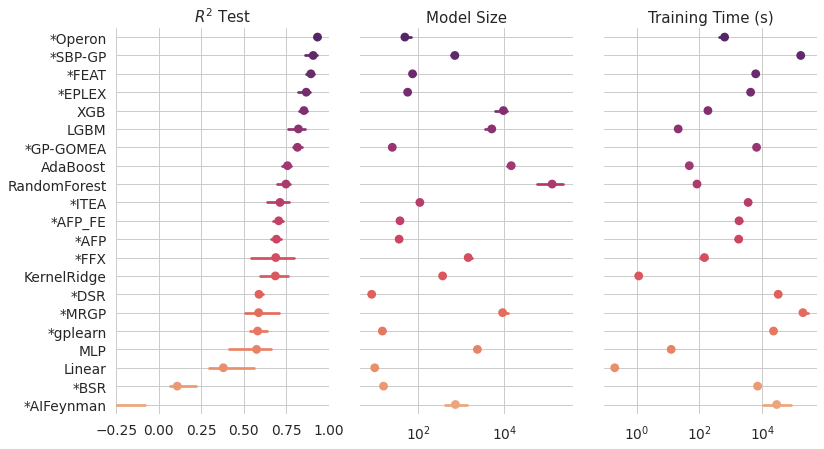

In [5]:
# Make the PairGrid
sns.set_style("whitegrid")
df_plot=df_sum.copy()

df_plot['*algorithm*'] = df_plot['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)
# different options
x_vars=[
#         'rmse_test',
#         'log_mse_test',
#         'r2_test_norm',
        'r2_test',
#         'r2_test_rank',
        'model_size',
#         'model_size_rank',
        'training time (s)',
]
order = df_plot.groupby('*algorithm*')[x_vars[0]].median().sort_values(
                    ascending='r2' not in x_vars[0] or 'rank' in x_vars[0]).index
g = sns.PairGrid(df_plot, 
                 x_vars=x_vars,
                 y_vars=['*algorithm*'],
                 height=6.5, 
                 aspect=0.6,
#                  hue='symbolic_dataset'
                )

# Draw a dot plot 
g.map(sns.pointplot, 
      size=10,
      orient="h",
      jitter=False,
      order=order,
      palette="flare_r",
      linewidth=1,
      markeredgecolor='w',
      join=False,
      estimator=np.median,
      n_boot=1000,
      ci=95
     )
# # Use semantically meaningful titles for the columns
titles = [x.replace('_',' ').title().replace('(S)','(s)').replace('R2','$R^2$') for x in x_vars]
g.axes.flat[0].set_ylabel('')
for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)
    ax.set_xlabel('')
    
    if any([n in title.lower() for n in ['size','time']]):
        ax.set_xscale('log')
    
    if title == '$R^2$ Test':
        ax.set_xlim([-.25,1])

    # Make the grid horizontal instead of vertical
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

save(name='_'.join(['pairgrid-pointplot']+x_vars))

## effect of friedman datasets

saving figs/black-box/friedman_comparison_pairgrid-pointplot_normalized_R2_test.pdf


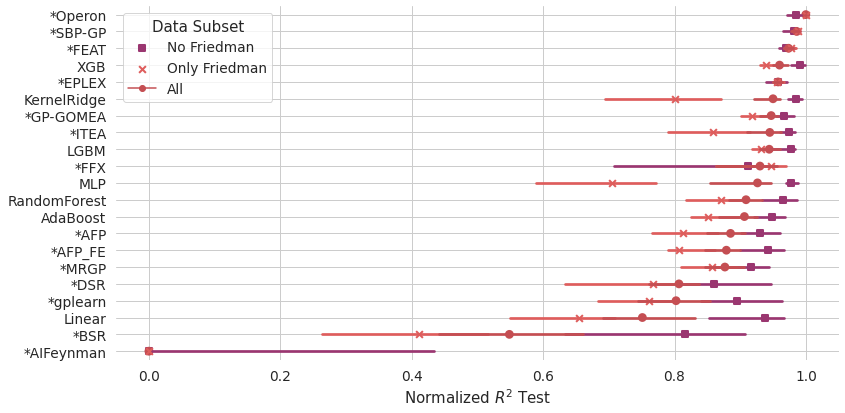

In [8]:
# Make the PairGrid
sns.set_style("whitegrid")
df_plot=df_sum.copy()
df_plot['*algorithm*'] = df_plot['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)
df_plot = df_plot[['*algorithm*','r2_test','r2_test_norm','r2_test_rank','friedman_dataset']]

x='r2_test'
markers = ['o','s','x']
colors = sns.color_palette('flare',n_colors=3)
for x in ['r2_test_norm']:
# for x in ['r2_test']:
    h = plt.figure(figsize=(12,6))
    ax = plt.gca()
    order = df_plot.groupby('*algorithm*')[x].median().sort_values(
                    ascending='r2' not in x or 'rank' in x).index
    i = 0
    axes = []
    g = sns.pointplot(ax=ax,
                  data=df_plot,
                  x=x,
                  y='*algorithm*',
                  hue='friedman_dataset',
                  size=10,
                  orient="h",
                  order=order,
                  markers=['s','x'],
                  palette="flare_r",
                  join=False,
                  estimator=np.median,
                  legend_out=True
                 )
    # all PMLB
    g2 = sns.pointplot(ax=ax,
                  data=df_plot,
                  x=x,
                  y='*algorithm*',
#                   hue='friedman_dataset',
                  size=10,
                  orient="h",
                  order=order,
                  color='r',
#                   palette="flare_r",
                  join=False,
                  estimator=np.median,
                  markers = ['o'],
                  legend_out=True
                 )
    # add all PMLB to legend
    handles, labels = ax.get_legend_handles_labels()
    #Create custom artists
    both = plt.Line2D((0,1),(0,0), color='r', marker='o', linestyle='-', label='All')
    handles.append(both)
    plt.legend(title='Data Subset',
               handles=handles, 
               labels=['No Friedman','Only Friedman','All'])
    
    if x=='r2_test':
        plt.xlim([-.5,1.0])
    if 'norm' in x:
        x='normalized_R2_test'
    sns.despine(left=True, bottom=True)
#         plt.title(prefix.replace('_',' ').title())
    axes.append(ax)
    i+=1
    plt.tight_layout()
    for ax in axes:
        ax.set_ylabel('')
        ax.set_xlabel(x.replace('_',' ').title().replace('(S)','(s)').replace('R2','$R^2$'))
        ax.yaxis.grid(True)
        ax.xaxis.grid(True)


    save(name='friedman_comparison_'+'_'.join(['pairgrid-pointplot']+[x]))

# training time versus dataset size

In [9]:
import pandas as pd
# for dataset, dfg in df_sum.groupby('dataset'):
def get_size(dataset,i):
    datadir = '../../../pmlb/datasets/'
    df = pd.read_csv(datadir+dataset+'/'+dataset+'.tsv.gz',sep='\t') 
    return df.shape[i]
df_sum.loc[:,'dataset_nsamples'] = df_sum['dataset'].apply(lambda x: get_size(x,0))
df_sum.loc[:,'dataset_nsamples_train'] = df_sum['dataset'].apply(lambda x: min(get_size(x,0),10000))
df_sum.loc[:,'dataset_nfeatures'] = df_sum['dataset'].apply(lambda x: get_size(x,1))
df_sum.loc[:,'dataset_npoints'] = df_sum['dataset_nsamples']*df_sum['dataset_nfeatures']
df_sum

,algorithm,dataset,random_state,training time (s),model_size,mse_test,mae_test,r2_test,training time (hr),r2_zero_test,...,r2_zero_test_rank,r2_zero_test_norm,rmse_test_rank,rmse_test_norm,log_mse_test_rank,log_mse_test_norm,dataset_nsamples,dataset_nsamples_train,dataset_nfeatures,dataset_npoints
0,AFP,1027_ESL,13879.5,1210.966865,20.5,0.365049,0.442612,0.830930,0.336380,0.830930,...,14.0,0.922184,14.0,0.139514,14.0,0.123830,488,488,5,2440
1,AFP,1028_SWD,13879.5,3017.658321,47.0,0.438023,0.538419,0.314517,0.838238,0.314517,...,14.0,0.836660,17.0,0.216281,17.0,0.208446,1000,1000,11,11000
2,AFP,1029_LEV,13879.5,2622.206193,23.5,0.433124,0.508817,0.521904,0.728391,0.521904,...,14.0,0.934869,14.0,0.075124,14.0,0.070675,1000,1000,5,5000
3,AFP,1030_ERA,13879.5,3007.024177,36.5,2.496171,1.299746,0.358716,0.835284,0.358716,...,15.0,0.917586,16.0,0.066810,16.0,0.070855,1000,1000,5,5000
4,AFP,1089_USCrime,13879.5,590.939726,25.0,549.423049,18.823004,0.639671,0.164150,0.639671,...,16.0,0.780937,15.0,0.200320,15.0,0.286474,47,47,14,658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2542,gplearn,695_chatfield_4,13879.5,28398.484904,1.0,311.234213,11.696317,0.843542,7.888468,0.843542,...,5.0,0.974512,6.0,0.010673,6.0,0.038788,235,235,13,3055
2543,gplearn,706_sleuth_case1202,13879.5,22506.032915,11.5,3185.450642,40.642813,0.661283,6.251676,0.661283,...,2.0,0.994737,3.0,0.009024,3.0,0.029265,93,93,7,651
2544,gplearn,712_chscase_geyser1,13879.5,26863.988673,3.0,36.237705,4.901875,0.760493,7.462219,0.760493,...,5.0,0.993841,1.0,0.000000,1.0,0.000000,222,222,3,666
2545,gplearn,banana,13879.5,31580.997657,33.5,0.421351,0.430139,0.571803,8.772499,0.571803,...,13.0,0.786982,13.0,0.158092,13.0,0.142943,5300,5300,3,15900


AttributeError: 'str' object has no attribute 'tight_layout'

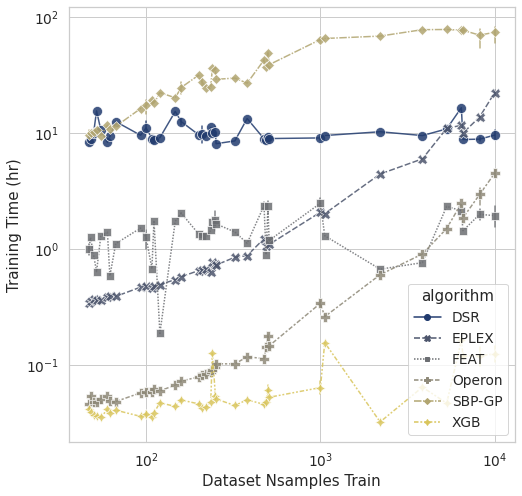

In [10]:
df_sum['Method Family'] = df_sum['algorithm'].apply(lambda x: 'Operon' if x=='Operon' else 'XGB' if x=='XGB' else 'Other Non-GP SR' if x in nongp_algs else 'Other GP SR' if x in gp_algs else 'Other ML')
sns.set_style('whitegrid')
for col in ['dataset_nsamples_train','dataset_nsamples','dataset_nfeatures','dataset_npoints']:
    plt.figure(figsize=(8,8))
    ax = sns.lineplot(
        data=df_sum.loc[df_sum.algorithm.isin(['Operon',
                                               'FEAT',
                                               'EPLEX',
                                               'SBP-GP',
                                               'XGB',
                                               'DSR',
                                               ])],
        x = col,
        y = 'training time (hr)',
#         hue='Method Family',
#         style='Method Family',
        hue='algorithm',
        style='algorithm',
        markers=True,
        palette='cividis',
        markersize=10,
        markerfacecolor=None,
        err_style='bars',
        alpha=0.85
#         facecolors=None
#         scatter_kws = {'facecolors':'none'}
    )
    ax.set_yscale('log')
    ax.set_xscale('log')
#     plt.legend(loc=[1.01,0])
    plt.xlabel(col.replace('_',' ').title())
    plt.ylabel('Training Time (hr)')
    save('training_time_'+col)

<!-- # scores on symbolic datasets (prelim) -->

# Pareto plot

Plot the method results as trade-offs between accuracy and simplicity

In [ ]:
np.random.seed(42)
def bootstrap(val, n = 1000, fn=np.mean):
    val_samples = []
    for i in range(n):
        sample = np.random.randint(0,len(val)-1, size=len(val))
        val_samples.append( fn(val[sample]) )
    m = np.mean(val_samples)
    sd = np.std(val_samples)
    ci_upper  = np.quantile(val_samples,0.95)
    ci_lower  = np.quantile(val_samples,0.05)
    return m, sd, ci_upper,ci_lower

In [ ]:
from pareto_utils import front
sns.set(font_scale=1, style='whitegrid')
labelsize=20
plt.figure(figsize=(7,7))
data = df_sum.copy() #.loc[df_sum.algorithm.isin(symbolic_algs)]
data['*algorithm*'] = data['algorithm'].apply(lambda x: x+'*' if x in symbolic_algs else x)
xcol = 'r2_test_rank'
ycol = 'model_size_rank'
palette = 'viridis'
cmap = sns.color_palette(palette=palette, n_colors=data.algorithm.nunique(), desat=None, as_cmap=False)
Z = 1.96 # 95% confidence 
i = 0
for alg, dg in data.groupby('*algorithm*'):
    x = dg[xcol].median() 
    y = dg[ycol].median()
    _, sdx, ciux, cilx = bootstrap(dg[xcol].values, fn=np.median, n=1000)
    _, sdy, ciuy, cily = bootstrap(dg[ycol].values, fn=np.median, n=1000)
    plt.plot(
             [cilx,ciux],
             [y, y],
             alpha=0.5,
             color=cmap[i]
            )
    plt.plot(
             [x, x],
             [cily,ciuy],
             alpha=0.5,
             color=cmap[i]
            )
    i += 1
# outline pareto front
pareto_data = data.groupby('*algorithm*').median()
objs = pareto_data[[xcol,ycol]].values
levels = 4
styles=['-','-.','--',':']
PFs = []
for el in range(levels):
    PF = front(objs[:,0],objs[:,1])
    objs[PF,:] = 100
    PFs.append(PF)
i = 0
for pfset in PFs:
    xset,yset = [],[]

    for pf in pfset:
        xset.append(pareto_data[xcol].values[pf])
        yset.append( pareto_data[ycol].values[pf] )
    linestyle=styles[i]
    plt.plot(xset,yset, styles[i]+'k', alpha=0.5, zorder=1)
    plt.gca().set_zorder(10)
    i+=1

ax = sns.scatterplot(
    ax = plt.gca(),
#     ax = g.ax_joint,
    data = data.groupby('*algorithm*').median(),
    x = xcol,
    y = ycol,
    style='*algorithm*',
    hue = '*algorithm*',
    s=300,
    palette=palette,
    #     edgecolor='k'
    legend=False,
)
ax.set_zorder(2)
xoff = .5
yoff = 0.3
for idx,row in pareto_data.iterrows():
    x=row[xcol]-xoff
    y=row[ycol]-yoff
    ha='right'
    
    if idx in ['Linear','AFP_FE*','MLP','MRGP*']:
        x=row[xcol]+xoff
        ha='left'
    elif idx == 'Operon*':
        x = row[xcol]+1
        y -= yoff
        ha='right'
    elif idx == 'gplearn*':
        y += yoff
        ha='right'
        
    plt.text(s=idx,
             x = x, 
             y = y,
             ha=ha,
             va='top',
             bbox=dict(facecolor='w', edgecolor='b', boxstyle='round', alpha=1)
            )
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
plt.xlabel(xcol.replace('_',' ').replace('r2','$R^2$').title(), fontsize=labelsize)
plt.ylabel(ycol.replace('_',' ').title(), fontsize=labelsize)
sns.despine(left=True, bottom=True)
save(name="pareto_plot_"+xcol+'_'+ycol)